In [1]:
# notebook settings
%load_ext autoreload
%autoreload 2

# external imports
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

# internal imports
from pympc.geometry.polyhedron import Polyhedron
from pympc.dynamics.discrete_time_systems import LinearSystem, AffineSystem, PieceWiseAffineSystem
from pympc.control.hybrid_benchmark.controllers import HybridModelPredictiveController

# Problem set-up

In [2]:
# numeric parameters of the system
m = 1.
r = .1
I = .4*m*r**2.
d = .4
l = .3
mu = .2
g = 10.
h = .05

In [3]:
# symbolic state
xb, yb, tb = sp.symbols('xb yb tb') # position of the ball
xf, yf = sp.symbols('xf yf') # position of the floor
xdb, ydb, tdb = sp.symbols('xdb ydb tdb') # velocity of the ball
xdf, ydf = sp.symbols('xdf ydf') # velocity of the floor
x = sp.Matrix([
    xb, yb, tb,
    xf, yf,
    xdb, ydb, tdb,
    xdf, ydf
])

# symbolic input
xd2f, yd2f = sp.symbols('xd2f yd2f') # acceleration of the floor
u = sp.Matrix([
    xd2f, yd2f
])

# contact forces
ftf, fnf = sp.symbols('ftf fnf') # floor force
ftc, fnc = sp.symbols('ftc fnc') # ceiling force

In [4]:
# ball velocity update
xdb_next = xdb + h*ftf/m - h*ftc/m
ydb_next = ydb + h*fnf/m - h*fnc/m - h*g
tdb_next = tdb + r*h*ftf/I + r*h*ftc/I

# ball position update
xb_next = xb + h*xdb_next
yb_next = yb + h*ydb_next
tb_next = tb + h*tdb_next

# floor velocity update
xdf_next = xdf + h*xd2f
ydf_next = ydf + h*yd2f

# floor position update
xf_next = xf + h*xdf_next
yf_next = yf + h*ydf_next

# state update
x_next = sp.Matrix([
    xb_next, yb_next, tb_next,
    xf_next, yf_next,
    xdb_next, ydb_next, tdb_next,
    xdf_next, ydf_next
])

In [5]:
# relative tangential velocity
sliding_velocity_floor = xdb_next + r*tdb_next - xdf_next
sliding_velocity_ceiling = xdb_next - r*tdb_next

# gap function floor
gap_floor = yb_next - yf_next

# gap function ceiling
gap_ceiling = d - 2.*r - yb_next

# ball distance to boundaries
ball_on_floor = sp.Matrix([
    xb_next - xf_next - l,
    xf_next - xb_next - l
])
ball_on_ceiling = sp.Matrix([
    xb_next - l,
    - xb_next - l
])

In [6]:
# state bounds
x_max = np.array([
    l, d-2.*r, 1.2*np.pi, # ball config
    l, d-2.*r-.05, # floor config
    2., 2., 10., # ball vel
    2., 2. # floor vel
])
x_min = - x_max

# input bounds
u_max = np.array([
    30., 30., # floor acc
])
u_min = - u_max

# domain bounds
xu = x.col_join(u)
xu_min = np.concatenate((x_min, u_min))
xu_max = np.concatenate((x_max, u_max))

In [7]:
# discrete time dynamics in mode 1
# (ball in the air)

# set forces to zero
f_m1 = {ftf: 0., fnf: 0., ftc: 0., fnc: 0.}

# get dynamics
x_next_m1 = x_next.subs(f_m1)
S1 = AffineSystem.from_symbolic(x, u, x_next_m1)

# build domain
D1 = Polyhedron.from_bounds(xu_min, xu_max)

# - gap <= 0 with floor and ceiling
gap_floor_m1 = gap_floor.subs(f_m1)
gap_ceiling_m1 = gap_ceiling.subs(f_m1)
D1.add_symbolic_inequality(xu, sp.Matrix([- gap_floor_m1]))
D1.add_symbolic_inequality(xu, sp.Matrix([- gap_ceiling_m1]))

# check domain
assert D1.bounded
assert not D1.empty

In [8]:
# discrete time dynamics in mode 2
# (ball sticking with the floor, not in contact with the ceiling)

# enforce sticking
fc_m2 = {ftc: 0., fnc: 0.}
ftf_m2 = sp.solve(sp.Eq(sliding_velocity_floor.subs(fc_m2), 0), ftf)[0]
fnf_m2 = sp.solve(sp.Eq(gap_floor.subs(fc_m2), 0), fnf)[0]
f_m2 = fc_m2.copy()
f_m2.update({ftf: ftf_m2, fnf: fnf_m2})

# get dynamics
x_next_m2 = x_next.subs(f_m2)
S2 = AffineSystem.from_symbolic(x, u, x_next_m2)

# build domain
D2 = Polyhedron.from_bounds(xu_min, xu_max)

# gap <= 0 with floor
D2.add_symbolic_inequality(xu, sp.Matrix([gap_floor_m1]))

# - gap <= 0 with ceiling
D2.add_symbolic_inequality(xu, sp.Matrix([- gap_ceiling_m1]))

# ball not falling down the floor
D2.add_symbolic_inequality(xu, ball_on_floor.subs(f_m2))

# friction cone
D2.add_symbolic_inequality(xu, sp.Matrix([ftf_m2 - mu*fnf_m2]))
D2.add_symbolic_inequality(xu, sp.Matrix([- ftf_m2 - mu*fnf_m2]))

# check domain
assert D2.bounded
assert not D2.empty

In [9]:
# discrete time dynamics in mode 3
# (ball sliding right on the floor, not in contact with the ceiling)

# enforce sticking
f_m3 = {ftf: -mu*fnf_m2, fnf: fnf_m2, ftc: 0., fnc: 0.}

# get dynamics
x_next_m3 = x_next.subs(f_m3)
S3 = AffineSystem.from_symbolic(x, u, x_next_m3)

# build domain
D3 = Polyhedron.from_bounds(xu_min, xu_max)

# gap <= 0 with floor
D3.add_symbolic_inequality(xu, sp.Matrix([gap_floor_m1]))

# - gap <= 0 with ceiling
D3.add_symbolic_inequality(xu, sp.Matrix([- gap_ceiling_m1]))

# ball not falling down the floor
D3.add_symbolic_inequality(xu, ball_on_floor.subs(f_m3))

# positive relative velocity
D3.add_symbolic_inequality(xu, sp.Matrix([- sliding_velocity_floor.subs(f_m3)]))

# check domain
assert D3.bounded
assert not D3.empty

In [10]:
# discrete time dynamics in mode 4
# (ball sliding left on the floor, not in contact with the ceiling)

# enforce sticking
f_m4 = {ftf: mu*fnf_m2, fnf: fnf_m2, ftc: 0., fnc: 0.}

# get dynamics
x_next_m4 = x_next.subs(f_m4)
S4 = AffineSystem.from_symbolic(x, u, x_next_m4)

# build domain
D4 = Polyhedron.from_bounds(xu_min, xu_max)

# gap <= 0 with floor
D4.add_symbolic_inequality(xu, sp.Matrix([gap_floor_m1]))

# - gap <= 0 with ceiling
D4.add_symbolic_inequality(xu, sp.Matrix([- gap_ceiling_m1]))

# ball not falling down the floor
D4.add_symbolic_inequality(xu, ball_on_floor.subs(f_m4))

# negative relative velocity
D4.add_symbolic_inequality(xu, sp.Matrix([sliding_velocity_floor.subs(f_m4)]))

# check domain
assert D4.bounded
assert not D4.empty

In [11]:
# discrete time dynamics in mode 5
# (ball sticking on the ceiling, not in contact with the floor)

# enforce sticking
ff_m5 = {ftf: 0., fnf: 0.}
ftc_m5 = sp.solve(sp.Eq(sliding_velocity_ceiling.subs(ff_m5), 0), ftc)[0]
fnc_m5 = sp.solve(sp.Eq(gap_ceiling.subs(ff_m5), 0), fnc)[0]
f_m5 = ff_m5.copy()
f_m5.update({ftc: ftc_m5, fnc: fnc_m5})

# get dynamics
x_next_m5 = x_next.subs(f_m5)
S5 = AffineSystem.from_symbolic(x, u, x_next_m5)

# build domain
D5 = Polyhedron.from_bounds(xu_min, xu_max)

# - gap <= 0 with floor
D5.add_symbolic_inequality(xu, sp.Matrix([- gap_floor_m1]))

# gap <= 0 with ceiling
D5.add_symbolic_inequality(xu, sp.Matrix([gap_ceiling_m1]))

# ball in contact with the ceiling
D5.add_symbolic_inequality(xu, ball_on_ceiling.subs(f_m5))

# friction cone
D5.add_symbolic_inequality(xu, sp.Matrix([ftc_m5 - mu*fnc_m5]))
D5.add_symbolic_inequality(xu, sp.Matrix([- ftc_m5 - mu*fnc_m5]))

# check domain
assert D5.bounded
assert not D5.empty

In [12]:
# discrete time dynamics in mode 6
# (ball sliding right on the ceiling, not in contact with the floor)

# enforce sticking
f_m6 = {ftc: -mu*fnc_m5, fnc: fnc_m5, ftf: 0., fnf: 0.}

# get dynamics
x_next_m6 = x_next.subs(f_m6)
S6 = AffineSystem.from_symbolic(x, u, x_next_m6)

# build domain
D6 = Polyhedron.from_bounds(xu_min, xu_max)

# - gap <= 0 with floor
D6.add_symbolic_inequality(xu, sp.Matrix([- gap_floor_m1]))

# gap <= 0 with ceiling
D6.add_symbolic_inequality(xu, sp.Matrix([gap_ceiling_m1]))

# ball in contact with the ceiling
D6.add_symbolic_inequality(xu, ball_on_ceiling.subs(f_m6))

# positive relative velocity
D6.add_symbolic_inequality(xu, sp.Matrix([- sliding_velocity_ceiling.subs(f_m6)]))

# check domain
assert D6.bounded
assert not D6.empty

In [13]:
# discrete time dynamics in mode 7
# (ball sliding left on the ceiling, not in contact with the floor)

# enforce sticking
f_m7 = {ftc: mu*fnc_m5, fnc: fnc_m5, ftf: 0., fnf: 0.}

# get dynamics
x_next_m7 = x_next.subs(f_m7)
S7 = AffineSystem.from_symbolic(x, u, x_next_m7)

# build domain
D7 = Polyhedron.from_bounds(xu_min, xu_max)

# - gap <= 0 with floor
D7.add_symbolic_inequality(xu, sp.Matrix([- gap_floor_m1]))

# gap <= 0 with ceiling
D7.add_symbolic_inequality(xu, sp.Matrix([gap_ceiling_m1]))

# ball in contact with the ceiling
D7.add_symbolic_inequality(xu, ball_on_ceiling.subs(f_m7))

# negative relative velocity
D7.add_symbolic_inequality(xu, sp.Matrix([sliding_velocity_ceiling.subs(f_m7)]))

# check domain
assert D7.bounded
assert not D7.empty

In [14]:
# list of dynamics
S_list = [S1, S2, S3, S4, S5, S6, S7]

# list of domains
D_list = [D1, D2, D3, D4, D5, D6, D7]

# PWA system
S = PieceWiseAffineSystem(S_list, D_list)

In [15]:
# controller parameters
N = 20
Q = np.diag([
    1., 1., .01,
    1., 1.,
    1., 1., .01,
    1., 1.
])*2. # times 2 to cancel out the 1/2 
R = np.diag([
    .01, .001
])*2. # times 2 to cancel out the 1/2 
P = np.zeros((S.nx, S.nx))

# terminal set and cost
X_N = Polyhedron.from_bounds(*[np.zeros(S.nx)]*2)

# mixed-integer formulations and norms of the objective
methods = ['PF', 'CH', 'BM', 'MLD']
norms = ['inf', 'one', 'two']

In [16]:
# initial condition
x0 = np.array([
    0., 0., np.pi,
    0., 0.,
    0., 0., 0.,
    0., 0.
])

# Comparison of the different mixed-integer formulations

In [ ]:
# solves of the MICP with all the methods and the norms (takes hours!)
solves = {}

# for all the norms of the objective
for norm in norms:
    print '\nnorm:', norm
    solves[norm] = {}
    
    # for all the mixed-integer formulations
    for method in methods:
        print '  \nmethod:', method
        
        # build the copntroller
        controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, method, norm)
        
        # cut solution if longer than 1 h
        controller.prog.setParam('TimeLimit', 3600)
        
        # solve and store result
        u_mip, x_mip, ms_mip, cost_mip = controller.feedforward(x0)
        solves[norm][method] = {
            'time': controller.prog.Runtime,
            'nodes': controller.prog.NodeCount,
            'mip_gap': controller.prog.MIPGap,
            'u': u_mip,
            'x': x_mip,
            'ms': ms_mip,
            'cost': cost_mip
        }
        
# save result
# np.save('data_hscc/flip_benchmark', solves)

In [17]:
# loads the results above and prints the results
solves = np.load('data_hscc/flip_benchmark.npy').item()
for norm in norms:
    print '\nnorm:', norm
    for method in methods:
        print '\n  method:', method
        print '    mip gap:', solves[norm][method]['mip_gap']
        print '    time:', solves[norm][method]['time']
        print '    nodes:', solves[norm][method]['nodes']


norm: inf

  method: PF
    mip gap: 0.0
    time: 439.396331072
    nodes: 56329.0

  method: CH
    mip gap: 0.0
    time: 318.190353155
    nodes: 95419.0

  method: BM
    mip gap: 0.924087316255
    time: 3600.05123186
    nodes: 4039189.0

  method: MLD
    mip gap: 1e+100
    time: 3600.01436591
    nodes: 2605461.0

norm: one

  method: PF
    mip gap: 4.03793586172e-09
    time: 464.133744955
    nodes: 144743.0

  method: CH
    mip gap: 0.0
    time: 211.899897814
    nodes: 157115.0

  method: BM
    mip gap: 0.911129504603
    time: 3600.0546639
    nodes: 3721402.0

  method: MLD
    mip gap: 1e+100
    time: 3600.0191009
    nodes: 2928378.0

norm: two

  method: PF
    mip gap: 0.987589379624
    time: 3600.0199821
    nodes: 14231.0

  method: CH
    mip gap: 6.032509825e-06
    time: 3537.11988091
    nodes: 1998523.0

  method: BM
    mip gap: 0.934560328191
    time: 3600.06194186
    nodes: 8476905.0

  method: MLD
    mip gap: 1e+100
    time: 3600.02337503
    n

# Animation

Animate the result with MeshCat (available at https://github.com/rdeits/meshcat-python)

In [18]:
import meshcat
import meshcat.transformations as tf
from meshcat.geometry import Box, Sphere, Cylinder, MeshLambertMaterial
from meshcat.animation import Animation

In [19]:
# load solution
solves = np.load('data_hscc/flip_benchmark.npy').item()

In [20]:
# initialize visualizer
vis = meshcat.Visualizer()
vis.open()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


<Visualizer using: <meshcat.visualizer.ViewerWindow instance at 0x7ff2a81aeb90> at path: <meshcat.path.Path object at 0x7ff2a83a9280>>

In [21]:
# geometric parameters of the ball and the paddle
tickness = .01
depth = .3

# colors of the scene
red = 0xff2222
blue = 0x2222ff
green = 0x22ff22
grey = 0x999999

# objects to animate
vis['ball'].set_object(
    Sphere(r),
    MeshLambertMaterial(color=blue)
)
vis['ball_stripe'].set_object(
    Cylinder(r/10., r*1.002), # a little larger than the ball to see it clearly
    MeshLambertMaterial(color=green)
)
vis['floor'].set_object(
    Box([depth, l*2., tickness]),
    MeshLambertMaterial(color=red)
)
vis['ceiling'].set_object(
    Box([depth, l*2., tickness]),
    MeshLambertMaterial(color=grey)
)

In [22]:
# initialize animation
anim = Animation()

# animate e.g. the solution with infinity norm and convex-hull method
for t, xt in enumerate(solves['inf']['CH']['x']):
    with anim.at_frame(vis, t*h*30) as frame: # 30 frames per second to get real time
        frame['ball'].set_transform(
            tf.translation_matrix([0, xt[0], xt[1]+r])
        )
        frame['ball_stripe'].set_transform(
            tf.translation_matrix([0, xt[0], xt[1]+r]).dot(
                tf.rotation_matrix(xt[2], [1.,0.,0.])
            )
        )
        frame['floor'].set_transform(
            tf.translation_matrix([0, xt[3], xt[4]-tickness/2.])
        )
        frame['ceiling'].set_transform(
            tf.translation_matrix([0, 0, d+tickness/2.])
        )

# visualize result
vis.set_animation(anim)

# Plot optimal mode sequence

In [23]:
# load results
solves = np.load('data_hscc/flip_benchmark.npy').item()

# optimal mode sequence e.g. in the infinity norm case
ms = solves['inf']['CH']['ms']

# double the initial mode for plot purpose
ms = [ms[0]] + ms

# names of the modes
ms_legend = [
    '',
    'Slide left on paddle',
    'Stick/roll on paddle',
    'Slide right on paddle',
    'No contact',
    'Slide left on ceiling',
    'Stick/roll on ceiling',
    'Slide right on ceiling'
]

# reorder the mode sequence in such a way that they math with the order of the names
ms_map = {0: 3, 1: 1, 2: 2, 3: 0, 4: 5, 5: 6, 6: 4}
ms_reordered = [ms_map[m] for m in ms]

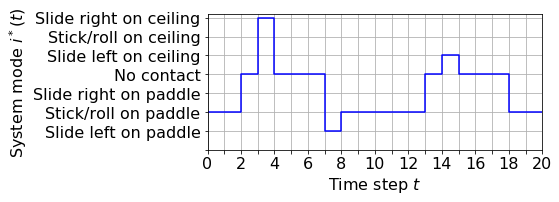

In [24]:
# change default size of matplotlib
plt.rc('font', size=16)

# initialize figure
plt.figure(figsize=(6,2.5))

# plot mode sequence
plt.step(range(N+1), ms_reordered, color='b')

# axis limits
plt.xlim(0, N)
plt.ylim(-.2, S.nm-.8)

# axis ticks
plt.xticks(range(N+1))
plt.gca().axes.xaxis.set_ticklabels([i if i%2==0 else '' for i in range(N+1)])
plt.yticks(range(-1,S.nm))
plt.gca().set_yticklabels(ms_legend)

# axis labels
plt.xlabel(r'Time step $t$')
plt.ylabel(r'System mode $i^*(t)$')

# misc
plt.grid(True)
# plt.savefig('optimal_mode_sequence.pdf',bbox_inches='tight')

# Compare formulations for different levels of relaxation

In [25]:
# load solution
solves = np.load('data_hscc/flip_benchmark.npy').item()

In [26]:
# cost of each relaxation as a function of time (takes approx. 2 minutes)
costs = {}

# for all the norms of the objective
for norm in norms:
    print '\nnorm:', norm
    costs[norm] = {}
    
    # for all the mixed-integer formulations
    for method in methods:
        print '  \nmethod:', method
        costs[norm][method] = []
        
        # build controller
        controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, method, norm)
        
        # fix the mode of the system to its optimal value for the initial t steps
        for ms in [solves[norm]['CH']['ms'][:t] for t in range(N+1)]:
            
            # solve the relaxation and normalize on the optimal value of the MICP
            cost = controller.solve_relaxation(x0, ms)[1]
            if cost is not None:
                cost /= solves[norm]['CH']['cost']
            costs[norm][method].append(cost)


norm: inf
  
method: PF
Academic license - for non-commercial use only
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
  
method: CH
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
  
method: BM
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
  
method: MLD
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored

norm: one
  
method: PF
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
  
method: CH
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
  
method: BM
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
  
method: MLD
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored

norm: two
  
method: PF
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
  
method: CH
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignore

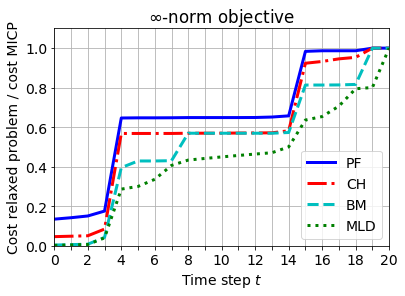

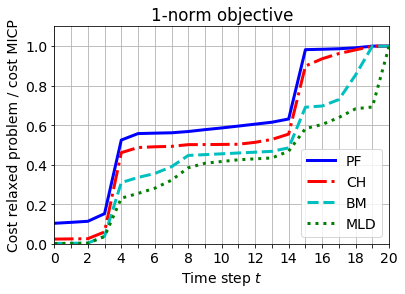

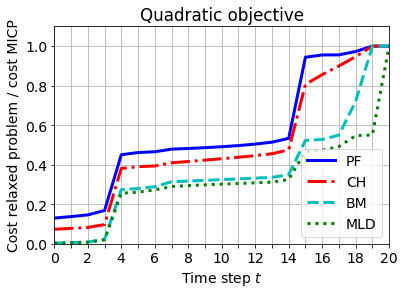

In [27]:
# change default colors and size of matplotlib
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
plt.rc('font', size=14)

# for all the norms of the objective
for norm in norms:
    
    # set line colors and styles
    colors = ['b', 'r', 'c','g']
    linestyles = ['-', '-.', '--', ':']
    
     # for all the mixed-integer formulations plot the relaxation ratio as a funtion of the time step
    for i, method in enumerate(methods):
        plt.plot(
            range(N+1),
            costs[norm][method],
            label=method,
            color=colors[i],
            linestyle=linestyles[i],
            linewidth=3
        )
        
    # axis limits
    plt.xlim((0, N))
    plt.ylim((0, 1.1))
    
    # plot titles
    if norm == 'inf':
        plt.title(r'$\infty$-norm objective')
    elif norm == 'one':
        plt.title(r'1-norm objective')
    elif norm == 'two':
        plt.title(r'Quadratic objective')
        
    # ticks
    plt.xticks(range(N+1)) # a tick per time step
    plt.gca().axes.xaxis.set_ticklabels([i if i%2==0 else '' for i in range(N+1)]) # label only even ticks
    
    # axis labels
    plt.xlabel(r'Time step $t$')
    plt.ylabel(r'Cost relaxed problem / cost MICP')

    # misc
    plt.legend(loc=4)
    plt.grid(True)
    # plt.savefig('relaxation_ratio_' + norm + '.pdf', bbox_inches='tight')
    plt.show()

# Objective as a function of the initial state ($x_1$ and $x_3$ only)

In [ ]:
# solve relaxations for all MI formulations (takes tens of minutes)

# n_samples by n_samples grid in x1 and x3
n_samples = 51
xb_samples = np.linspace(0., x_max[0], n_samples)
tb_samples = np.linspace(-np.pi, np.pi, n_samples)

# cost of the relaxation for each point
cost = {'xb_samples': xb_samples, 'tb_samples':tb_samples}

# for all the norms of the objective
for norm in norms:
    print '\nnorm:', norm
    cost[norm] = {}
    
    # for all the mixed-integer formulations
    for method in methods:
        print '  \nmethod:', method
        
        # build controller
        controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, method, norm)
        
        # cost matrix
        cost_mat = np.empty([n_samples]*2)
        
        # solve one convex program per point in the grid
        for i, xb in enumerate(xb_samples):
            for j, tb in enumerate(tb_samples):
                print(str(i) + ',' + str(j) + '   \r'),
                
                # initial state
                x0 = np.array([xb,0.,tb] + [0.]*7)
                
                # cost of the relaxation
                cost_mat[i,j] = controller.solve_relaxation(x0, {})[1]
                
        # fill matrix
        cost[norm][method] = cost_mat

# save data
# np.save('data_hscc/cost_relaxation_different_intial_conditions', cost)

In [ ]:
# plot cost of the relaxation as a function of x1 and x3

# change default size of matplotlib
plt.rc('font', size=18)

# load cost matrices
cost = np.load('data_hscc/cost_relaxation_different_intial_conditions.npy').item()

# create grid x1 and x3
xb_samples = cost['xb_samples']
tb_samples = cost['tb_samples']
Xb, Tb = np.meshgrid(xb_samples, tb_samples)

# number of level curves in each plot
n_levels = 10

# for all the norms of the objective
for norm in norms:
    
    # for all the mixed-integer formulations
    for method in methods:
        print '\nnorm: %s, method: %s' % (norm, method)
        
        # initialize figure
        plt.figure(figsize=(6., 2.3))
        
        # cost matrix
        cm = cost[norm][method]

        # set desired levels and draw the contour plot
        levels = [(i+1)*np.nanmax(cm)/n_levels for i in range(n_levels)]
        cp = plt.contour(Xb, Tb, cm.T, levels=levels, cmap='viridis_r')
        
        # get colorbar
        cb = plt.colorbar(cp)
        
        # ticks of the colorbar (only first and last) limited to 2 decimals
        cb.set_ticks([cb.locator()[0],cb.locator()[-1]])
        cb.set_ticklabels(['%.2f'%cb.locator()[0],'%.2f'%cb.locator()[-1]])
        
        # axis ticks
        plt.xticks(np.linspace(0., x_max[0], 6))
        plt.yticks(np.linspace(-np.pi, np.pi, 5))
        plt.gca().axes.yaxis.set_ticklabels([r'$-\pi$',r'$-\pi/2$',0,r'$\pi/2$',r'$\pi$'])
        
        # misc
        plt.grid(True)
        # plt.savefig('cost_' + method + '_' + norm + '.pdf',bbox_inches='tight')
        plt.show()

In [ ]:
# samples of the MICP optimal value (takes days!)

# n_samples by n_samples grid in x1 and x3
n_samples = 11
xb_samples = np.linspace(0., x_max[0], n_samples)
tb_samples = np.linspace(-np.pi, np.pi, n_samples)

# cost of the MICP for each point
cost = {'xb_samples': xb_samples, 'tb_samples':tb_samples}

# for all the norms of the objective
for norm in norms:
    print '\nnorm:', norm
    
    # build controller
    controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, 'CH', norm)
    
    # cut after 5 h
    controller.prog.setParam('TimeLimit', 18000)
    
    # cost matrix
    cost_mat = np.empty([n_samples]*2)
        
    # solve one MICP program per point in the grid
    for i, xb in enumerate(xb_samples):
        for j, tb in enumerate(tb_samples):
            print(str(i) + ',' + str(j) + '   \r'),

            # initial state
            x0 = np.array([xb,0.,tb] + [0.]*7)
            
            # cost of the MICP
            cost_mat[i,j] = controller.feedforward(x0)[3]
            
    # fill matrix
    cost[norm] = cost_mat

# save data
# np.save('data_hscc/cost_micp_different_intial_conditions', cost)

In [ ]:
# plot cost of the MICP as a function of x1 and x3

# change default size of matplotlib
plt.rc('font', size=18)

# load cost matrices
cost = np.load('data_hscc/cost_micp_different_intial_conditions.npy').item()

# create grid x1 and x3
xb_samples = np.concatenate([[i]*len(cost['tb_samples']) for i in cost['xb_samples']])
tb_samples = cost['tb_samples'].tolist()*len(cost['xb_samples'])

# number of level curves in each plot
n_levels = 10

# for all the norms of the objective
for norm in norms:
    print '\nnorm:', norm
    
    # initialize figure
    plt.figure(figsize=(6., 2.3))
    
    # scatter the samples of the optimal value function
    c = cost[norm].flatten()
    sc = plt.scatter(
        xb_samples,
        tb_samples,
        c=c,
        cmap=plt.cm.get_cmap('viridis_r')
    )
    
    # get colorbar
    cb = plt.colorbar(sc)
    
    # colorbar ticks
    cb.set_ticks([min(c), max(c)])
    cb.set_ticklabels(['%.2f'%min(c),'%.2f'%max(c)])
    
    # axis limits
    plt.xlim(-.01,.31)
    plt.ylim(-np.pi-.3,np.pi+.3)
    
    # axis ticks
    plt.xticks(np.linspace(0., x_max[0], 6))
    plt.yticks(np.linspace(-np.pi, np.pi, 5))
    plt.gca().axes.yaxis.set_ticklabels([r'$-\pi$',r'$-\pi/2$',0,r'$\pi/2$',r'$\pi$'])
    
    # misc
    plt.grid(True)
    plt.gca().set_axisbelow(True)
    # plt.savefig('cost_mip_' + norm + '.pdf',bbox_inches='tight')
    plt.show()